### Import librairies

In [1]:
import sys
import os
sys.path.insert(0,'..')

In [28]:
import numpy as np
import pandas as pd
import numpy.random as npr
import torch
import torch.nn as nn
from data_utils import *
from relu import *
from maxpool import *
from normpool import *
from models import *
from data_utils import *
import torch.optim as optim
import torch.nn.init as init
import torchvision
from torchvision import datasets, transforms
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm.notebook import tqdm
%matplotlib inline

In [29]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
#torch.use_deterministic_algorithms(True)
#os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    cudnn.benchmark = False
    # Deterministic convolutions
    torch.backends.cudnn.deterministic = True

### Builds models 

In [30]:
normpool_native = lambda:NormPool1(2,2)
normpool_custom = lambda:NormPool2(2,2)

def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_uniform_(m.weight, mode='fan_in')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, 0, 0.01)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
        
def build_models(network, precision):
    if network == "vgg11":
        net1 = VGG("VGG11", maxpool_fn=normpool_native)
        net2 = VGG("VGG11", maxpool_fn=normpool_custom)
    elif network == "resnet18":
        net1 = resnet18(norm_layer=nn.Identity, maxpool_fn=normpool_native)
        net2 = resnet18(norm_layer=nn.Identity, maxpool_fn=normpool_custom)
    elif network == "densenet121":
        net1 = densenet121(norm_layer=nn.Identity,maxpool_fn=normpool_native, num_classes=10)
        net2 = densenet121(norm_layer=nn.Identity, maxpool_fn=normpool_custom, num_classes=10)
    elif network == "lenet":
        net1 = LeNet5(maxpool_fn=normpool_native)
        net2 = LeNet5(maxpool_fn=normpool_custom)
    else:
        raise ValueError("Invalid network name.")

    for net in [net1, net2]:
        net.to(device)
        net.apply(init_weights)
        if precision == 16:
            net = net.half()
        if precision == 64:
            net = net.double()
    net2.load_state_dict(net1.state_dict())

    return net1, net2

def compute_norms(net1, net2):
    diff = 0
    for p1, p2 in zip(net1.parameters(), net2.parameters()):
        diff += torch.norm(p1.grad - p2.grad,1)
    return diff.item()

In [31]:
def plot_histogram(data, precision, bitsString):
    # Create bins
    if precision == 16 :
        exponents = np.arange(-8, 2 , 1)
    if precision == 32 :
        exponents = np.arange(-9, 2 , 1)
    if precision == 64:
        exponents = np.arange(-18, -13 , 1)

    bins = 10.0**exponents
    bins = np.append(bins, 0.0)  # Add a bin for zero
    bins = np.sort(bins)
    
    # Calculate the histogram
    hist, bin_edges = np.histogram(data, bins=bins)
    hist = hist / np.sum(hist) * 100
    
    # Add the zero bin to the histogram
    num_zeros = np.sum(data == 0)
    zero_bin = num_zeros / len(data) * 100
    hist = np.insert(hist, 0, zero_bin)  # Prepend the zero_bin to hist
    
    # Prepend zero to exponents
    exponents = np.insert(exponents, 0, 0)
    hist = np.delete(hist, 1)
    exponents = np.delete(exponents, 1)
    

    fig, ax = plt.subplots(figsize=(8, 5))  # Increase figure size

    # Set a custom color for the bars
    bar_color = '#1f77b4'
    error_color = 'r'  # set error bar color

    # Original bar plot without errors
    ax.bar(range(len(hist)), hist, tick_label=exponents, color=bar_color)

    # Set labels and title
    ax.set_xlabel(r'$\log_{10}(magnitude)$', fontsize=18)
    ax.set_ylabel('Proportion (%)', fontsize=18)

    # Set y-axis scale to logarithmic
    ax.set_yscale('log')

    # Set the y-axis limits
    ax.set_ylim(top=100)

    # Add a grid
    ax.grid(True, linestyle='--', alpha=0.6, linewidth=0.7)  # thinner lines

    # Customize tick parameters
    ax.tick_params(axis='x', labelsize=14)  # rotate and align x-labels, increase font size
    ax.tick_params(axis='y', which='both', width=0.5, length=4, labelsize=14, pad=5)  # increase font size and padding

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust the plot layout
    plt.tight_layout()
    if torch.backends.cudnn.deterministic == False :   
        plt.savefig('figures/normpool_'+ bitsString + '.pdf', bbox_inches='tight')
    else:   
        plt.savefig('figures/normpool_'+ bitsString + '.pdf', bbox_inches='tight')


In [32]:
def diffMaxpool(nb_experiments, network, dataset, precision):
    bitsString = "32 bits"
    if precision == 64:
        bitsString = "64 bits"
        nb_experiments = 1
        print('==> Double precision models..')
    if precision == 16:
        bitsString = "16 bits"
        print('==> Half precision models..')
        
    if dataset == "cifar10":
        trainloader, testloader = get_cifar10_loaders()
    elif dataset == "cifar100":
        trainloader, testloader = get_cifar100_loaders()
    elif dataset == "svhn":
        trainloader, testloader = get_svhn_loaders()
    elif dataset == "mnist":
        trainloader, testloader = get_mnist_loaders()
    
    df = pd.DataFrame(columns=["run_id", "network", "dataset", "precision",  "norm"])
           
    for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
        (net1, net2) = build_models(network, precision)
        opt = optim.SGD([{'params': net1.parameters()}, {'params': net2.parameters()}], lr=0)
        for i, (x, y) in enumerate(trainloader):
            #free the gradients accumulated during the backward pass
            opt.zero_grad()
            x = x.to(device)
            if precision == 16:
                x = x.half()
            if precision == 64:
                x = x.double()
            y = y.to(device)
            y1, y2 = net1(x), net2(x)
            loss1 = nn.CrossEntropyLoss()(y1, y)
            loss2 = nn.CrossEntropyLoss()(y2, y)
            loss1.backward()
            loss2.backward()
            norm = compute_norms(net1, net2)           
            df = df.append({
                    "run_id": i * (nb_experiments + 1),
                    "network": network,
                    "dataset": dataset,
                    "precision": precision,
                    "norm" : norm}, ignore_index=True)
            
    plot_histogram(np.array(df.norm), precision, bitsString)
    
    if precision == 16:
        threshold  = df[df['norm']>0]['norm'].min()
    else :
        threshold = df['norm'].max()
        
    return threshold

In [33]:
nb_experiments = 100

### LeNet-5

==> Half precision models..


run:   0%|          | 0/100 [00:00<?, ?it/s]

1.1920928955078125e-07

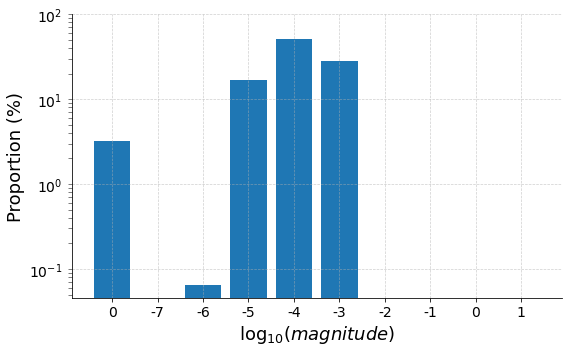

In [34]:
diffMaxpool(100, 'lenet','mnist', 16)